In [1]:
import cartopy.crs as ccrs # just for plotting
from glob import glob
import matplotlib.pyplot as plt # just for plotting
import numpy as np
import os
import pandas as pd
from pygris import counties, states
import xarray as xr # also need to install netcdf4 and dask[complete]
import zarr

In [2]:
# method to fix the weird WRF indexing in the original NetCDF files
# and load the time/space dimensions into memory

# def preprocess(d):
#     d = d.rename_dims({
#         'Time': 'time',
#     }).rename_vars({
#         'XLAT': 'lat',
#         'XLONG': 'lon',
#     })
#     d['time'] = pd.to_datetime(
#         d.Times.load().astype(str).str.replace('_', ' ')
#     )
#     d = d.drop_vars(['Times'])
#     d['lat'] = d.lat.isel(time=0).load()
#     d['lon'] = d.lon.isel(time=0).load()
#     return d


In [24]:
# I used this to convert the NetCDFs
# NOTE that it may be important to process them in time order...
# NOTE not sure what happens if you append_dim out of order

# for i, f in enumerate(sorted(glob('./tgw_wrf_*.nc'))):
#     d = preprocess(xr.open_dataset(f))
#     d = d.chunk({'time': d.time.size, 'south_north': d.south_north.size, 'west_east': int(d.west_east.size/2)})
#     if i==0:
#         d.to_zarr('./data/tgw_wrf_rcp85hotter_hourly_2088_fewer_time_chunks.zarr')
#     else:
#         d.to_zarr('./data/tgw_wrf_rcp85hotter_hourly_2088_fewer_time_chunks.zarr', append_dim='time')
#     d.close()


In [2]:
# prepare dataset of counties and states for subsetting

# CONUS states
conus_states = states(cb=True, year=2020, cache=True).to_crs("epsg:4326")
conus_states = conus_states[~conus_states.NAME.isin([
    'Alaska','American Samoa','Puerto Rico','United States Virgin Islands',
    'Hawaii','Guam','Commonwealth of the Northern Mariana Islands',
])]

# CONUS counties
conus_counties = counties(cb=True, year=2020, cache=True).to_crs("epsg:4326")
conus_counties = conus_counties[conus_counties.STATEFP.isin(
    conus_states.STATEFP
)]


In [3]:
def get_tgw_subset(
    *,
    start: str, # 'YYYY-MM-DD' or 'YYYY-MM-DDTHH:MM:SS'
    end: str, # 'YYYY-MM-DD' or 'YYYY-MM-DDTHH:MM:SS'
    county_fips: str = None, # county FIPS code to keep, None for all
    state_abbreviation: str = None, # State abbreviation to keep, None for all
    min_lat: float = None, # minimum latitude in WGS84 (epsg:4326)
    max_lat: float = None, # maximum latitude in WGS84 (epsg:4326)
    min_lon: float = None, # minimum longitude in WGS84 (epsg:4326)
    max_lon: float = None, # maximum longitude in WGS84 (epsg:4326)
    variables = None, # list of variables to keep, None for all
    data_store = './data/tgw_wrf_rcp85hotter_hourly_2088_fewer_time_chunks.zarr', # path to the zarr
    load = True, # if True, load the data before returning; otherwise return the chunked dask dataset
    write_to_file = False, # if a path, write subset to that path; if False don't
):

    # NOTE that certain variables (precipitation, etc) are presented as "cumulative",
    #      meaning that the user may actually need one timestep before the requested
    #      start time in order to fully resolve those variables
    # TODO this is not accounted for in this method

    # NOTE that the WRF data presented in WGS84 (epsg:4326) projection as is the case
    #      here is NOT on a rectilinear grid, which can be confusing to work with, but
    #      the native WRF projection IS on a rectilinear grid but those coordinates are
    #      not provided by default (see the python package salem for more details...)

    # NOTE the data_store must be used to filter by scenario,
    #      but users may benefit from a wrapper for that functionality too

    # open the files with dask chunks
    # TODO may be more efficient chunking method than the default...
    d = xr.open_mfdataset(data_store, engine='zarr', parallel=True)

    # load the coordinates so they can be used as indexers
    d.lat.load();
    d.lon.load();
    d.time.load();

    # subset by variables
    # TODO may help to ignore or just warn about requested variables that don't
    #      exist, rather than just fail
    if variables is not None:
        d = d[variables]
    
    # subset by date
    d = d.sel(time=slice(start, end))

    # subset by space
    # NOTE that there could be errors caused by use of -180 to 180 vs 0 to 360 nomenclature
    # TODO may want to build in a buffer to be sure to catch the edges of the shape
    if (state_abbreviation is not None):
        state_bounds = conus_states[conus_states.STUSPS == state_abbreviation.upper()].bounds.iloc[0]
        d = d.where(
            (d.lat>=state_bounds.miny) &
            (d.lat<=state_bounds.maxy) &
            (d.lon>=state_bounds.minx) &
            (d.lon<=state_bounds.maxx),
            drop=True,
        )
    if (county_fips is not None):
        county_bounds = conus_counties[conus_counties.GEOID == county_fips].bounds.iloc[0]
        d = d.where(
            (d.lat>=county_bounds.miny) &
            (d.lat<=county_bounds.maxy) &
            (d.lon>=county_bounds.minx) &
            (d.lon<=county_bounds.maxx),
            drop=True,
        )
    if (min_lat is not None) or (max_lat is not None) or (min_lon is not None) or (max_lon is not None):
        d = d.where(
            (d.lat>=(min_lat if min_lat is not None else -np.Inf)) &
            (d.lat<=(max_lat if max_lat is not None else np.Inf)) &
            (d.lon>=(min_lon if min_lon is not None else -np.Inf)) &
            (d.lon<=(max_lon if max_lon is not None else np.Inf)),
            drop=True,
        )

    # write the data to file if requested
    if write_to_file:
        d.to_netcdf(write_to_file)

    # loading the data fully into memory takes some time
    # a user skilled with dask may benefit from keeping the data unloaded
    # until the end of their data transformations
    if load:
        return d.load()
    return d
    

In [4]:
%%time
# HOME = os.environ.get("HOME")
# DATA_DIR = os.path.join(HOME, "data/s3")
d = get_tgw_subset(
    start='2088-01-01',
    end='2089-01-01T00:00:00',
    variables=['U10', 'V10'],
    # county_fips='53033',
    state_abbreviation='wa',
    # min_lat=45.543830,
    # max_lat=49.002405,
    # min_lon=-124.7336,
    # max_lon=-116.9161,
    # data_store=f'{DATA_DIR}/tgw_wrf_rcp85hotter_hourly_2088_default_chunks.zarr',
    load=False,
    write_to_file='./subset.nc',
)

CPU times: user 11.7 s, sys: 11.2 s, total: 22.9 s
Wall time: 16.8 s


In [32]:
# look at the subset
d

<xarray.Dataset>
Dimensions:  (time: 8784, south_north: 44, west_east: 56)
Coordinates:
    lat      (south_north, west_east) float32 44.25 44.28 44.31 ... 50.17 50.19
    lon      (south_north, west_east) float32 -124.2 -124.0 ... -117.6 -117.5
  * time     (time) datetime64[ns] 2088-01-01T01:00:00 ... 2089-01-01
Dimensions without coordinates: south_north, west_east
Data variables:
    U10      (time, south_north, west_east) float32 dask.array<chunksize=(168, 44, 56), meta=np.ndarray>
    V10      (time, south_north, west_east) float32 dask.array<chunksize=(168, 44, 56), meta=np.ndarray>
Attributes: (12/142)
    ADAPT_DT_MAX:                    140.0
    ADAPT_DT_MIN:                    36.0
    ADAPT_DT_START:                  48.0
    AERCU_FCT:                       1.0
    AERCU_OPT:                       0
    AER_ANGEXP_OPT:                  1
    ...                              ...
    WEST-EAST_PATCH_END_STAG:        425
    WEST-EAST_PATCH_END_UNSTAG:      424
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0

CPU times: user 12.6 s, sys: 11.7 s, total: 24.3 s
Wall time: 4.06 s


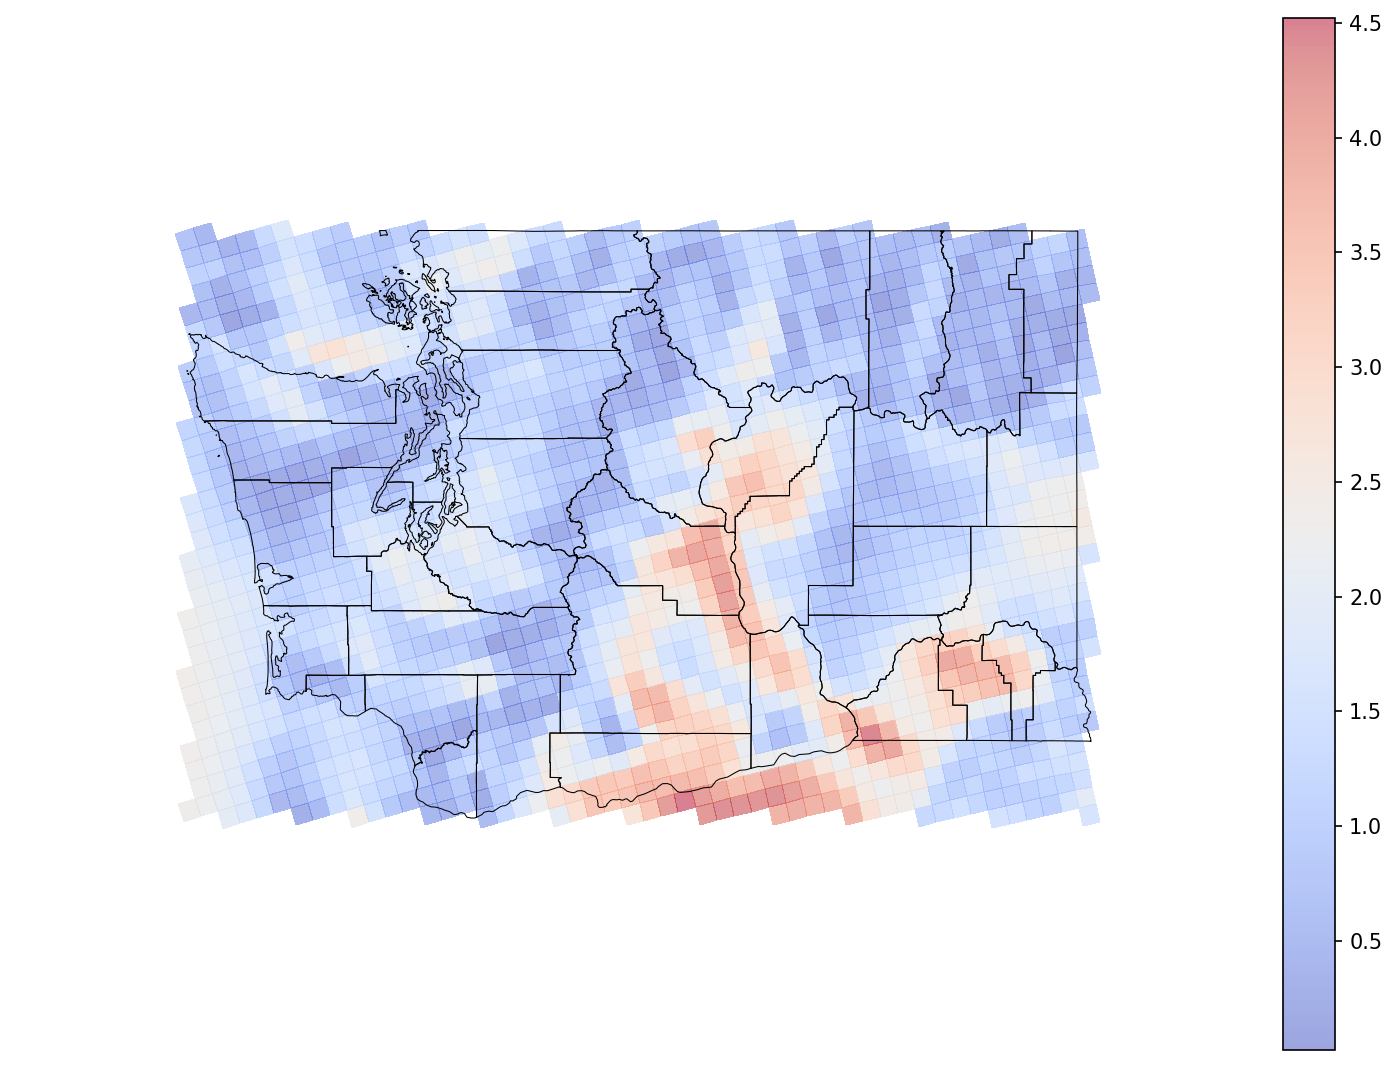

In [33]:
%%time
# plot the subset in the usual WGS84 datum
fig = plt.figure(figsize=(10.8, 7.2), dpi=150, layout='tight')
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
conus_counties[conus_counties.STUSPS == 'WA'].boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, color='black')
((d.U10.mean(dim='time')**2 + d.V10.mean(dim='time')**2)**(1/2)).plot(ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", alpha=0.5, cmap='coolwarm')
ax.set_title('');

CPU times: user 15.5 s, sys: 11.8 s, total: 27.3 s
Wall time: 4.68 s


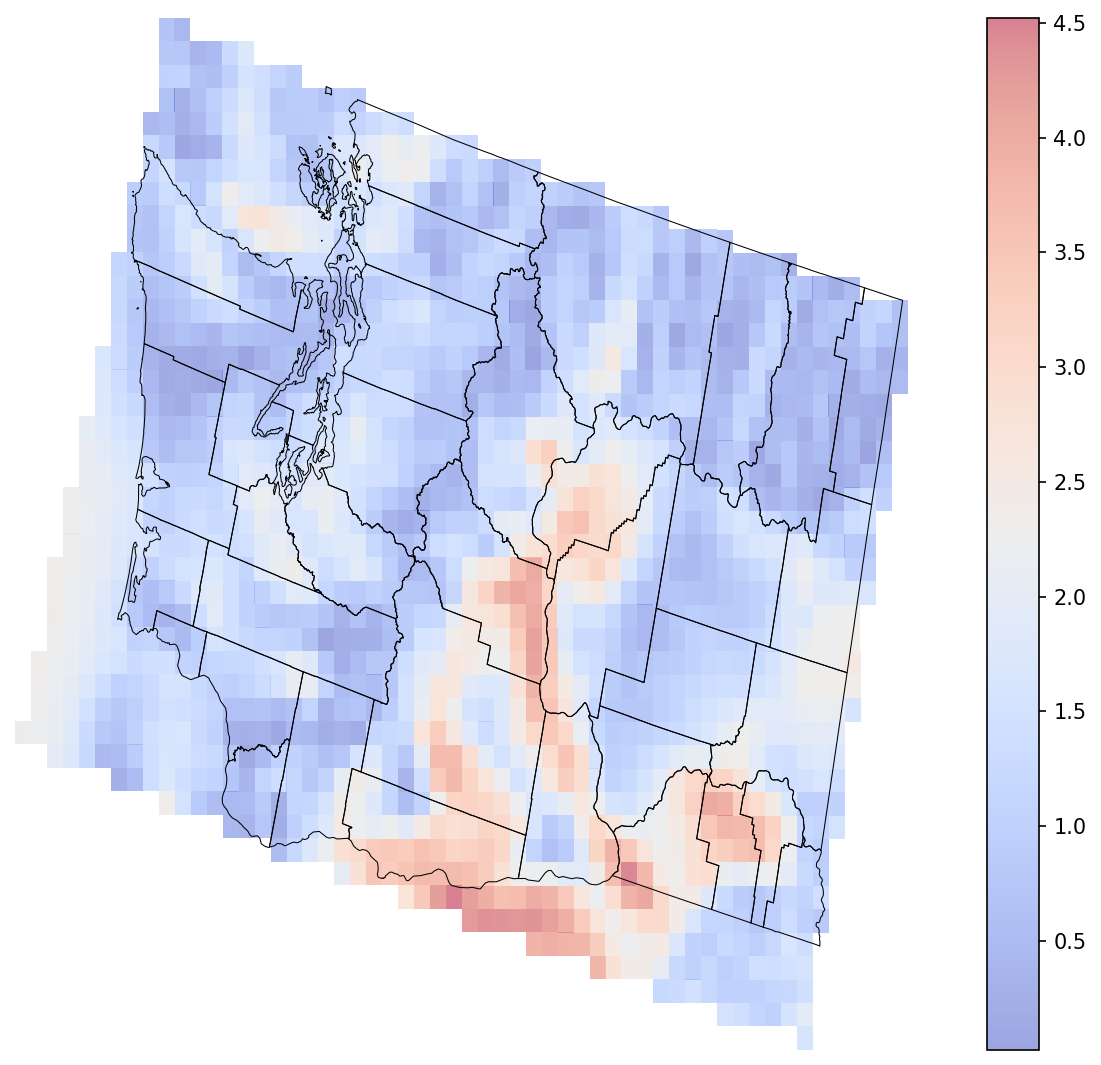

In [34]:
%%time
# plot the subset in the TGW-WRF native projection
# '+proj=lcc +lat_0=40.0000076293945 +lon_0=-97 +lat_1=30 +lat_2=45 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
tgw_crs = ccrs.LambertConformal(
    central_longitude=-97.0,
    central_latitude=40.0000076293945,
    standard_parallels=(30, 45),
    globe=None,
)
fig = plt.figure(figsize=(10.8, 7.2), dpi=150, layout='tight')
ax = plt.axes(projection=tgw_crs, frameon=False)
conus_counties[conus_counties.STUSPS == 'WA'].boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, color='black')
((d.U10.mean(dim='time')**2 + d.V10.mean(dim='time')**2)**(1/2)).plot(ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", alpha=0.5, cmap='coolwarm')
ax.set_title('');